In [1]:
import numpy as np
import pandas as pd
import hierarchical_umap as h_umap
import time

import matplotlib.pyplot as plt
import demap
import scprep
import math
import os

from sklearn.neighbors import NearestNeighbors

from sklearn.utils import check_array

from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder

In [2]:
import demap
import random
import math
from sklearn.metrics import euclidean_distances

from sklearn.neighbors import NearestNeighbors

from scipy.stats import pearsonr

def correlation(X, X_emb):
    
    
    high = []
    emb = []
    
    for i in range(X.shape[0]):
        for j in range(i+1, X.shape[0]):
            high.append(np.linalg.norm(X[i]-X[j]))
            emb.append(np.linalg.norm(X_emb[i]-X_emb[j]))
    
    high = np.array(high)
    emb = np.array(emb)
    
    return pearsonr(high, emb)[0]

def stress(X, X_emb):
    
    DE = euclidean_distances(X_emb)
    DE = DE/np.max(DE)
    DH = euclidean_distances(X)
    DH = DH/np.max(DH)
    stress = 0.5 * np.sum((DE - DH)**2)
    
    return np.sqrt(stress/(0.5*np.sum(DH**2)))
    

def neighborhood_preservation(X, X_emb, Khigh=30):
    
    neigh_high = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_high.fit(X)
    high_dists, high_indices = neigh_high.kneighbors(X)


    neigh_emb = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_emb.fit(X_emb)
    emb_dists, emb_indices = neigh_emb.kneighbors(X_emb)

    npres = np.zeros(Khigh)
    
    for k in range(1, Khigh+1):
        for i in range(X.shape[0]):
            high_current = high_indices[i][1:k+1]
            emb_current = emb_indices[i][1:k+1]
            
            tp = len(np.intersect1d(high_current, emb_current))
            
            npres[k-1] += (tp/k)
        
        
    npres /= float(X.shape[0])
    
    return npres


In [80]:
fashionTrain = pd.read_csv('data/fashion-train.csv')

fashionX = fashionTrain.values[:,2:]
fashionY = fashionTrain.values[:, 1].astype(int)

# print(fashionX.shape, fashionY.shape)

X = fashionX
X = normalize(X)
y = fashionY


# X = np.load('./data/MNIST_70000.npy')
# y = np.load('./data/MNIST_70000_label.npy').astype(int)
# X = normalize(X)
# data = pd.read_csv('data/mnist_max_pooling2d_dense.data', header=None)
# data = data.drop(columns=[0])
# X = data.values[:, :-1]
# y = data.values[:, -1]

# X = np.loadtxt("data/mammals-20000_features.txt")
# y = np.loadtxt("data/mammals-20000_classes.txt")
# X = normalize(X)

# data = pd.read_csv('data/gene_expression.csv')
# X = data.values[:, :-1]
# y = data.values[:, -1]
# X = np.log(X+1)
# X = PCA(n_components=100).fit_transform(X)
# X = normalize(X)

def load_scRNAseq():
    download_path = os.path.expanduser("~/Documentos/HierarchicalUMAP/umap-cpp/umap/cpp/data")
    sparse=True
    T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
    T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
    T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
    T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
    T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
    print("done 1")
    filtered_batches = []
    for batch in [T1, T2, T3, T4, T5]:
        batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
        batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
        filtered_batches.append(batch)
    del T1, T2, T3, T4, T5
    print("done 2")
    EBT_counts, sample_labels = scprep.utils.combine_batches(
        filtered_batches, 
        ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
        append_to_cell_names=True
    )
    del filtered_batches # removes objects from memory
    print("done 3")
    EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)
    EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)
    mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
    EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')
    print("done 4")
    EBT_counts = scprep.transform.sqrt(EBT_counts)
    
    le = LabelEncoder()
    le.fit(sample_labels)
    labels = le.transform(sample_labels)
    print("done 5")
    X = PCA(n_components=100).fit_transform(EBT_counts.values)
    
    return X, labels


def load_vertebral():
    
    vertebral = pd.read_csv('data/vertebral.csv')
    names = vertebral.columns.values
    X = vertebral.values[:, :-3]
    y = vertebral.values[:, -3]
    X = normalize(X)
#     X = X + abs(X.min()) + 1 
    return X, y, names[:-3]

def load_iris():
    iris = pd.read_csv('data/iris.csv')
    names = iris.columns.values
    X = iris.values[:, :-3]
    y = iris.values[:, -3]
    
    return X, y, names[:-3]
    
def load_sun():
        
    X = np.load('./data/small_sun.npy')
    y = np.zeros(X.shape[0]).astype(int)
    return X, y

def load_covid():
    X = np.load('./data/embedding_relevant.npy')
    
    
    
    # X = PCA(n_components=50).fit_transform(X)
    dfX = pd.DataFrame(X)
    dfX.columns = np.arange(X.shape[1])
    dfX['label'] = [-1]*X.shape[0]
    y = np.zeros(X.shape[0]).astype(int)
    
    return X, y, dfX

def load_activations():
    X = np.loadtxt('./data/activations6400_conv2d_X.txt')
#     X = normalize(X)
    y = np.loadtxt('./data/activations6400_conv2d_labels.txt')
    
    return X, y
    
X, y, dfX = load_covid()    
# X, y = load_scRNAseq()
# X, y, names = load_vertebral()
# X, y, names = load_iris()
# print(names)

# X, y = load_sun()


X = check_array(X, dtype=np.float32, accept_sparse='csr', order='C')
dataset='mnist'



# X_noised = X + np.random.normal(loc=0, scale=1, size=X.shape)*0.04
print(X.shape, y.shape)
dfX.head()
dfX.to_csv('data/embedding_covid19.csv', index=False)

(40794, 768) (40794,)


In [62]:
hUmap = h_umap.HUMAP('precomputed', np.array([0.2, 0.2]), 100, 0.15, "NNDescent", 0.0, True)
# hUmap.set_landmarks_nwalks(50)
# hUmap.set_landmarks_wl(50)
# hUmap.set_influence_wl(10)
# hUmap.set_influence_wl(100)
hUmap.set_influence_neighborhood(0)
hUmap.set_distance_similarity(False)
hUmap.set_path_increment(False)
hUmap.fit(X, y)

In [63]:
# X_3 = X[hUmap.get_original_indices(3), :]
X_2 = X[hUmap.get_original_indices(2), :]
X_1 = X[hUmap.get_original_indices(1), :]

# embedding_3 = hUmap.get_embedding(3)
# y_3 = hUmap.get_labels(3)

# embedding_2 = hUmap.get_embedding(2)


# embedding_1 = hUmap.get_embedding(1)


# embedding_0 = hUmap.get_embedding(0)


In [64]:
# import seaborn as sns
# sns.set(rc = {
#     'figure.figsize': (10,5)
# })
# plt.scatter(embedding_0[:, 0], embedding_0[:, 1], c=y_0, alpha=0.7, cmap='viridis')

# inds = y_0 == 2

# plt.scatter(embedding_0[inds, 0], embedding_0[inds, 1], c = 'black', alpha=1)
# plt.show()
# indices = np.arange(len(y_0))[inds]
# indices, len(indices)

In [65]:
# inds = y_0 == 2
# indices = np.arange(len(y_0))[inds]

# explanations = hUmap.explain(10000, 100, indices)

# explanations.shape
# # class1_explanations = explanations[inds]
# # print(class1_explanations[:10])
# # print(X[inds][:10])

# # max_ = -1.0
# # for i in range(len(indices)):
# #     if X[indices[i], 4] > max_:
# #         max_ = X[indices[i], 5]
# #         ind_max = i

# # print('ind_max:', ind_max)

In [66]:
# index = 0
# feature = 3

# print(indices[index])

# sns.set(rc={'figure.figsize':(22,8.27)})
# sns.heatmap(explanations[index].T)


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# axes[0].scatter(embedding_0[:, 0], embedding_0[:, 1], c = explanations[index][:, feature], 
#                 s=100, alpha=1, 
#             vmin=explanations[index].min(), vmax=explanations[index].max(), cmap='viridis')
# axes[1].scatter(embedding_0[:, 0], embedding_0[:, 1], c = X[:, feature], 
#                 s=100, alpha=1, cmap='Reds',
#             vmin=X[:, feature].min(), vmax=X[:, feature].max())
# fig.tight_layout()

In [67]:


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# axes[0].scatter(embedding_0[inds, 0], embedding_0[inds, 1], c = explanations[i][:, 5], s=100, alpha=1, 
#             vmin=class1_explanations.min(), vmax=class1_explanations.max(), cmap='viridis')
# axes[1].scatter(embedding_0[inds, 0], embedding_0[inds, 1], c = X[inds, 5], s=100, alpha=1, cmap='Reds',
#             vmin=X[:, 5].min(), vmax=X[:, 5].max())
# fig.tight_layout()


In [68]:
# plt.scatter(embedding_3[:, 0], embedding_3[:, 1], c=y_3, alpha=1, cmap='Spectral')
# plt.savefig('figs/'+dataset+'-humap-level3.png')
# plt.show()

In [69]:

# indices_3 = random.sample(range(0, len(y_3)), min(3000, len(y_3)))

# subset_emb_3 = embedding_3[indices_3]
# subset_X_3 = X_3[indices_3]

# print("Computing DEMaP...")
# print("demap: %.4f" % (demap.DEMaP(subset_X_3, subset_emb_3)))
# print("Computing Stress...")
# print("stress: ", stress(subset_X_3, subset_emb_3))
# print("Computing correlation...")
# print("correlation: ", correlation(subset_X_3, subset_emb_3))


# print("Computing Neighborhood Preservation...")
# npres = neighborhood_preservation(subset_X_3, subset_emb_3)
# plt.plot(np.arange(30), npres)
# plt.xlabel("# of neighbors", fontsize=14)
# plt.ylabel("N. Preservation", fontsize=14)
# plt.savefig('figs/'+dataset+'-humap-level3-np.png')
# plt.show()

In [70]:
embedding_2 = hUmap.transform(2)
y_2 = hUmap.get_labels(2)



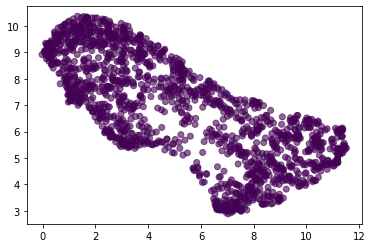

In [71]:
plt.scatter(embedding_2[:, 0], embedding_2[:, 1], c=y_2, alpha=0.6, cmap='viridis')
plt.show()

In [72]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=1).fit(embedding_2)
kmeans.labels_


array([2, 2, 2, ..., 0, 2, 3], dtype=int32)

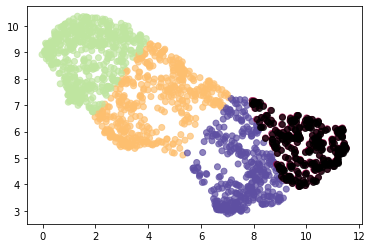

In [73]:


plt.scatter(embedding_2[:, 0], embedding_2[:, 1], c=kmeans.labels_, alpha=0.7, cmap='Spectral')

indices_black = np.arange(embedding_2.shape[0])[kmeans.labels_ == 0]

plt.scatter(embedding_2[indices_black, 0], embedding_2[indices_black, 1], c='black', alpha=0.7)



In [74]:
len(indices_black)

311

In [75]:
embedding_cluster1 = hUmap.project_indices(2, indices_black)
y_cluster1 = hUmap.get_labels_selected()
indices_cluster1 = hUmap.get_indices_selected()
X_cluster1 = X_1[indices_cluster1]



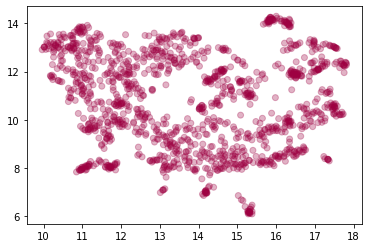

In [76]:
plt.scatter(embedding_cluster1[:, 0], embedding_cluster1[:, 1], c=y_cluster1, alpha=0.3,cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-expand2.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (1631, 768) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.9327
Computing Stress...
stress:  0.2556410249585124
Computing correlation...
correlation:  0.9029012998789724
Computing Neighborhood Preservation...


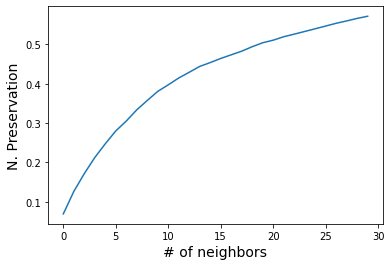

In [77]:
indices_2 = random.sample(range(0, len(y_2)), min(3000, len(y_2)))

subset_emb_2 = embedding_2[indices_2]
subset_X_2 = X_2[indices_2]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_2, subset_emb_2)))
print("Computing Stress...")
print("stress: ", stress(subset_X_2, subset_emb_2))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_2, subset_emb_2))


print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_2, subset_emb_2)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-level2-np.png')
plt.show()

In [78]:
embedding_1 = hUmap.transform(1)
y_1 = hUmap.get_labels(1)


embedding_1.shape

(8158, 2)

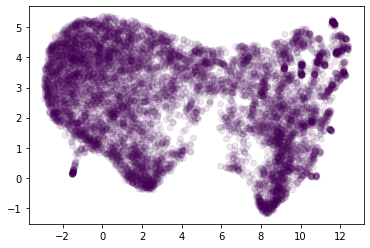

In [79]:
plt.scatter(embedding_1[:, 0], embedding_1[:, 1], c=y_1, alpha=0.1, cmap='viridis')
plt.show()

In [14]:
indices_1 = random.sample(range(0, len(y_1)), min(3000, len(y_1)))

subset_emb_1 = embedding_1[indices_1]
subset_X_1 = X_1[indices_1]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_1, subset_emb_1)))
print("Computing Stress...")
print("stress: ", stress(subset_X_1, subset_emb_1))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_1, subset_emb_1))

print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_1, subset_emb_1)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-level1-np.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (3000, 768) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.9491
Computing Stress...
stress:  0.21832594263854527
Computing correlation...


KeyboardInterrupt: 

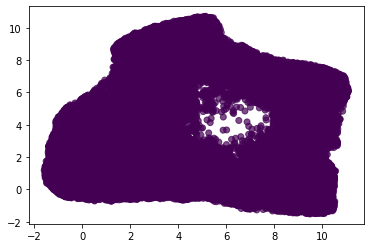

(40794, 2)

In [10]:
embedding_0 = hUmap.transform(0)
y_0 = y


plt.scatter(embedding_0[:, 0], embedding_0[:, 1], c=y_0, alpha=0.7, cmap='viridis')
plt.savefig('figs/'+dataset+'-humap-level0.png')
plt.show()
embedding_0.shape

Computing DEMaP...
demap: 0.6662
Computing Stress...
stress:  0.4190099423082116
Computing correlation...
correlation:  0.4943090600715966
Computing Neighborhood Preservation...


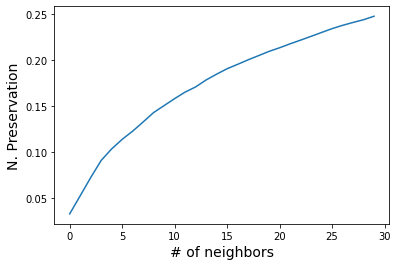

In [75]:
indices_0 = random.sample(range(0, len(y_0)), min(3000, len(y_0)))

subset_emb_0 = embedding_0[indices_0]
subset_X_0 = X[indices_0]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_0, subset_emb_0)))
print("Computing Stress...")
print("stress: ", stress(subset_X_0, subset_emb_0))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_0, subset_emb_0))



print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_0, subset_emb_0)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-level0-np.png')
plt.show()

In [ ]:
embedding_cluster1 = hUmap.project(3, np.array([1, 3]))
y_cluster1 = hUmap.get_labels_selected()
indices_cluster1 = hUmap.get_indices_selected()
X_cluster1 = X_2[indices_cluster1]

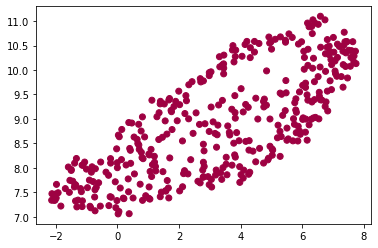

In [130]:

plt.scatter(embedding_cluster1[:, 0], embedding_cluster1[:, 1], c=y_cluster1, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-expand2.png')
plt.show()

In [30]:
indices_cluster1 = random.sample(range(0, len(y_cluster1)), min(5000, len(y_cluster1)))

subset_emb_cluster1 = embedding_cluster1[indices_cluster1]
subset_X_cluster1 = X_cluster1[indices_cluster1]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_cluster1, subset_emb_cluster1)))
print("Computing Stress...")
print("stress: ", stress(subset_X_cluster1, subset_emb_cluster1))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_cluster1, subset_emb_cluster1))



print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_cluster1, subset_emb_cluster1)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-expand2-np.png')
plt.show()

NameError: name 'y_cluster1' is not defined

In [7]:
embedding_cluster = hUmap.project(2, np.array([0,2,3,4,6,8]))
y_cluster = hUmap.get_labels_selected()
indices_cluster = hUmap.get_indices_selected()
X_cluster = X_1[indices_cluster]

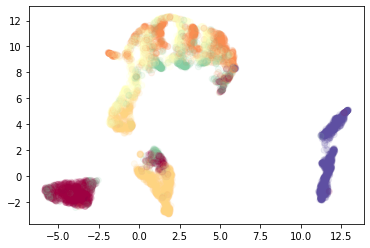

(7050, 2)

In [8]:
plt.scatter(embedding_cluster[:, 0], embedding_cluster[:, 1], c=y_cluster, alpha=0.1, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-expand1.png')
plt.show()
embedding_cluster.shape

In [9]:
indices_cluster = random.sample(range(0, len(y_cluster)), min(5000, len(y_cluster)))

subset_emb_cluster = embedding_cluster[indices_cluster]
subset_X_cluster = X_cluster[indices_cluster]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_cluster, subset_emb_cluster)))
print("Computing Stress...")
print("stress: ", stress(subset_X_cluster, subset_emb_cluster))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_cluster, subset_emb_cluster))



print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_cluster, subset_emb_cluster)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-expand1-np.png')
plt.show()

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (5000, 784) is expensive. Consider setting n_pca.
  UserWarning,


KeyboardInterrupt: 

In [10]:
embedding_cluster0 = hUmap.project(1, np.array([0,2,3,4,6,8]))
y_cluster0 = hUmap.get_labels_selected()
indices_cluster0 = hUmap.get_indices_selected()
X_cluster0 = X[indices_cluster0]

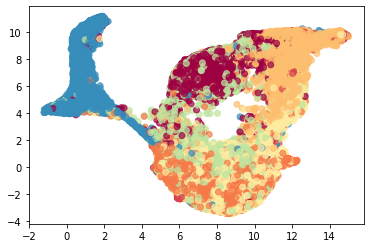

(36233, 2)

In [11]:
plt.scatter(embedding_cluster0[:, 0], embedding_cluster0[:, 1], c=y_cluster0, alpha=0.7, cmap='Spectral')
plt.savefig('figs/'+dataset+'-humap-expand2.png')
plt.show()
embedding_cluster0.shape

Computing DEMaP...


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (5000, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap: 0.7929
Computing Stress...
stress:  0.36403483035853984
Computing correlation...
correlation:  0.6862131880756643
Computing Neighborhood Preservation...


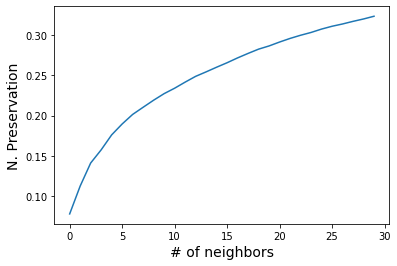

In [51]:
indices_cluster0 = random.sample(range(0, len(y_cluster0)), min(5000, len(y_cluster0)))

subset_emb_cluster0 = embedding_cluster0[indices_cluster0]
subset_X_cluster0 = X_cluster0[indices_cluster0]

print("Computing DEMaP...")
print("demap: %.4f" % (demap.DEMaP(subset_X_cluster0, subset_emb_cluster0)))
print("Computing Stress...")
print("stress: ", stress(subset_X_cluster0, subset_emb_cluster0))
print("Computing correlation...")
print("correlation: ", correlation(subset_X_cluster0, subset_emb_cluster0))


print("Computing Neighborhood Preservation...")
npres = neighborhood_preservation(subset_X_cluster0, subset_emb_cluster0)
plt.plot(np.arange(30), npres)
plt.xlabel("# of neighbors", fontsize=14)
plt.ylabel("N. Preservation", fontsize=14)
plt.savefig('figs/'+dataset+'-humap-expand3-np.png')
plt.show()